In [1]:
%%capture --no-stdout

from parameters import parameters as p
import pprint, sys, math, os
sys.path.append(p["plate_tectonic_tools_path"])
from subduction_convergence import subduction_convergence_over_time
import numpy as np
import pygplates

'''
INPUT: 2D array with the following columns
    0  longitude
    1  latitude 
    2  subducting convergence (relative to subduction zone) velocity magnitude (in cm/yr)
    3  subducting convergence velocity obliquity angle (angle between subduction zone normal 
        vector and convergence velocity vector)
    4  subduction zone absolute (relative to anchor plate) velocity magnitude (in cm/yr)
    5  subduction zone absolute velocity obliquity angle (angle between subduction zone normal 
        vector and absolute velocity vector)
    6  length of arc segment (in degrees) that current point is on
    7  subducting arc normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
    8  subducting plate ID
    9  overriding plate ID
    10 subduction zone (trench) plate ID
    11 subducting plate velocity (vector3D)
    12 overriding plate velocity (vector3D)
    https://github.com/EarthByte/PlateTectonicTools/blob/master/ptt/subduction_convergence.py
    
OUTPUT:
    0  lon #longitude
    1  lat #latitude 
    2  convergence_velocity_magnitude (convRate) # the magnitude of convergence velocity(cm/yr) 
    3  arc_length (distance)                     # segmentLength(km) 
    4  orthogonal_subducting_velocity (orthAbs)  # orthogonal absolute subducting plate velocity 
    5  orthogonal_overriding_velocity (orthOP)   # orthogonal overriding plate velocity
    6  orthogonal_trench_velocity (orthTrench)   # orthogonal trench velocity(cm/yr)
    7  subducting_obliquity (subObliquity)       # subducting obliquity(degrees)
    8  arc_angle (subPolarity)                   # subducting arc normal azimuth angle(degrees)
    9  distEdge                                  # DistanceToSlabEdge(km)
    10 orthogonal_convergence_velocity           # orthogonal convergence velocity (cm/yr)
    11 parallel_convergence_velocity (convPar)   # parallel convergence velocity (cm/yr)
    12 parallel_subducting_velocity (parAbs)     # parallel absolute subducting plate velocity (mm/yr) 
    13 parallel_overriding_velocity (parOP)      # parallel overriding plate velocity (mm/yr)
    14 parallel_trench_velocity (parTrench)      # parallel trench velocity (cm/yr)
    15 distEdgeTotal                             # toal Distance To Slab Edge(km)
    16 s_pid                                     # subducting plate id
    17 trench_pid                                #subduction zone plate id (AKA trench plate id) 
    18 o_pid                                     #overriding plate id
'''
def compute_extra_stats(input_data):
    ret = []
    #get arc vectors from arc normal azimuth angle
    arc_vectors = pygplates.LocalCartesian.convert_from_magnitude_azimuth_inclination_to_geocentric(
            np.array(input_data)[:,(1,0)], 
            [(1,x,0) for x in np.array(input_data)[:,7]])
    
    for idx, row in enumerate(input_data):
        subducting_obliquity = pygplates.Vector3D.angle_between(
            np.array(row[11].to_xyz()), #subducting plate velocity
            np.array(arc_vectors[idx].to_xyz())) #arc vector
        
        overriding_obliquity = pygplates.Vector3D.angle_between(
            np.array(row[12].to_xyz()), #overriding plate velocity
            np.array(arc_vectors[idx].to_xyz())) #arc vector
        
        #######################fill the fields below################
        #longitude
        lon = row[0]
        
        #latitude
        lat = row[1]
        
        #the magnitude of convergence velocity(cm/yr) 
        convergence_velocity_magnitude = row[2] 
        
        #segmentLength(km) 
        arc_length = np.radians(row[6]) * pygplates.Earth.mean_radius_in_kms
        
        #orthogonal absolute subducting plate velocity 
        orthogonal_subducting_velocity = np.dot(
            np.array(row[11].to_xyz()),
            np.array(row[11].to_xyz())) * math.cos(math.radians(subducting_obliquity))
        
        #orthogonal overriding plate velocity
        orthogonal_overriding_velocity = np.dot(
            np.array(row[12].to_xyz()),
            np.array(row[12].to_xyz())) * math.cos(math.radians(overriding_obliquity))
        
        #orthogonal trench velocity(cm/yr)
        orthogonal_trench_velocity = row[4] * math.cos(math.radians(row[5]))
        
        #subducting obliquity(degrees)
        subducting_obliquity = row[3]
        
        #subducting arc normal azimuth angle(degrees)
        arc_angle = row[7]
        
        # DistanceToSlabEdge(km)
        distEdge = 0#TODO
        
        # orthogonal convergence velocity (cm/yr),
        orthogonal_convergence_velocity = convergence_velocity_magnitude * math.cos(math.radians(row[3]))
        
        # parallel convergence velocity (cm/yr)
        parallel_convergence_velocity = convergence_velocity_magnitude * math.sin(math.radians(row[3]))
        
        # Parallel absolute subducting plate velocity (mm/yr) 
        parallel_subducting_velocity = np.dot(
            np.array(row[11].to_xyz()),
            np.array(row[11].to_xyz())) * math.cos(math.radians(subducting_obliquity))
        
        # Parallel overriding plate velocity (mm/yr)
        parallel_overriding_velocity = np.dot(
            np.array(row[12].to_xyz()),
            np.array(row[12].to_xyz())) * math.cos(math.radians(overriding_obliquity))
        
        # parallel trench velocity (cm/yr)
        parallel_trench_velocity = row[4] * math.sin(math.radians(row[5]))
        
        # toal Distance To Slab Edge(km)
        distEdgeTotal = 0#TODO
        
        #subducting plate id
        s_pid = row[8]
        
        #subduction zone plate id (AKA trench plate id) 
        trench_pid = row[10]
        
        #overriding plate id
        o_pid = row[9]
        
        ret.append((lon, lat, convergence_velocity_magnitude, arc_length,\
            orthogonal_subducting_velocity, orthogonal_overriding_velocity,\
            orthogonal_trench_velocity, subducting_obliquity, arc_angle, distEdge,\
            orthogonal_convergence_velocity, parallel_convergence_velocity,\
            parallel_subducting_velocity, parallel_overriding_velocity,\
            parallel_trench_velocity, distEdgeTotal,\
            s_pid, trench_pid, o_pid))
    return ret
 
    
def append_velocity(stats, pid_index, time, delta_time, rotation_model):
    new_stats = []
    sorted_stats = sorted(stats, key = lambda x: x[pid_index]) #sort by plate id
    from itertools import groupby
    for pid, group in groupby(sorted_stats, lambda x: x[pid_index]):  #group by plate id
        #print pid
        grouped_stats = [x for x in group]
        points = np.array(grouped_stats)[:,(1,0)]
        rotation = rotation_model.get_rotation(time, pid, time + delta_time, anchor_plate_id=0)
        velocities = pygplates.calculate_velocities(
            points, rotation, delta_time, pygplates.VelocityUnits.cms_per_yr)
        #print(np.array(velocities).shape)
        for i in range(len(grouped_stats)):
            new_stats.append(grouped_stats[i] + tuple([velocities[i]]))
    
    return new_stats



if __name__ == '__main__':
    pp = pprint.PrettyPrinter(indent=2)
    pp.pprint(p)  
    
    kwargs = {    
        'output_distance_to_nearest_edge_of_trench':True,
        'output_distance_to_start_edge_of_trench':True,
        'output_convergence_velocity_components':True,
        'output_trench_absolute_velocity_components':True,
        'output_subducting_absolute_velocity':True,
        'output_subducting_absolute_velocity_components':True}

    return_code = subduction_convergence_over_time(
            p['convergence_data_filename_prefix'],
            p['convergence_data_filename_ext'],
            p["rotation_files"],
            p["topology_files"],
            math.radians(p["threshold_sampling_distance_degrees"]),
            p["time"]["start"],
            p["time"]["end"],
            p["time"]["step"],
            p["velocity_delta_time"],
            p['anchor_plate_id'],
            output_gpml_filename = None,
            **kwargs)
    
    result_dir=p['convergence_data_dir']
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    os.system('mv {0}*{1} {2}'.format( 
        p['convergence_data_filename_prefix'], p['convergence_data_filename_ext'], result_dir))
    print('The result data has been saved in {}!'.format(result_dir))        

{ 'anchor_plate_id': 0,
  'convergence_data_filename_ext': 'csv',
  'convergence_data_filename_prefix': 'conv_data',
  'plate_tectonic_tools_path': '../../PlateTectonicTools/ptt/',
  'result_dir': './convergence_data',
  'rotation_files': ['../data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'],
  'threshold_sampling_distance_degrees': 0.2,
  'time': { 'end': 20, 'start': 0, 'step': 10},
  'topology_files': [ '../data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml.gz',
                      '../data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml.gz'],
  'velocity_delta_time': 1}
The result data has been saved in ./convergence_data!


In [49]:
test = np.array(ret)
print(test.shape)
print(np.sum(test[:,13]==test[:,14]))
data = test[(test[:,13]==test[:,14])][:,(12,13,14)].astype(int)
coords = test[(test[:,13]==test[:,14])][:,(0,1)]
result = []
for row in zip(coords, data):
    result.append((row[0][0],row[0][1],row[1][0],row[1][1],row[1][2]))
#print result
np.savetxt('pids_same.txt', result, fmt='%1.2f %1.2f %i %i %i')

(2945, 15)
1444


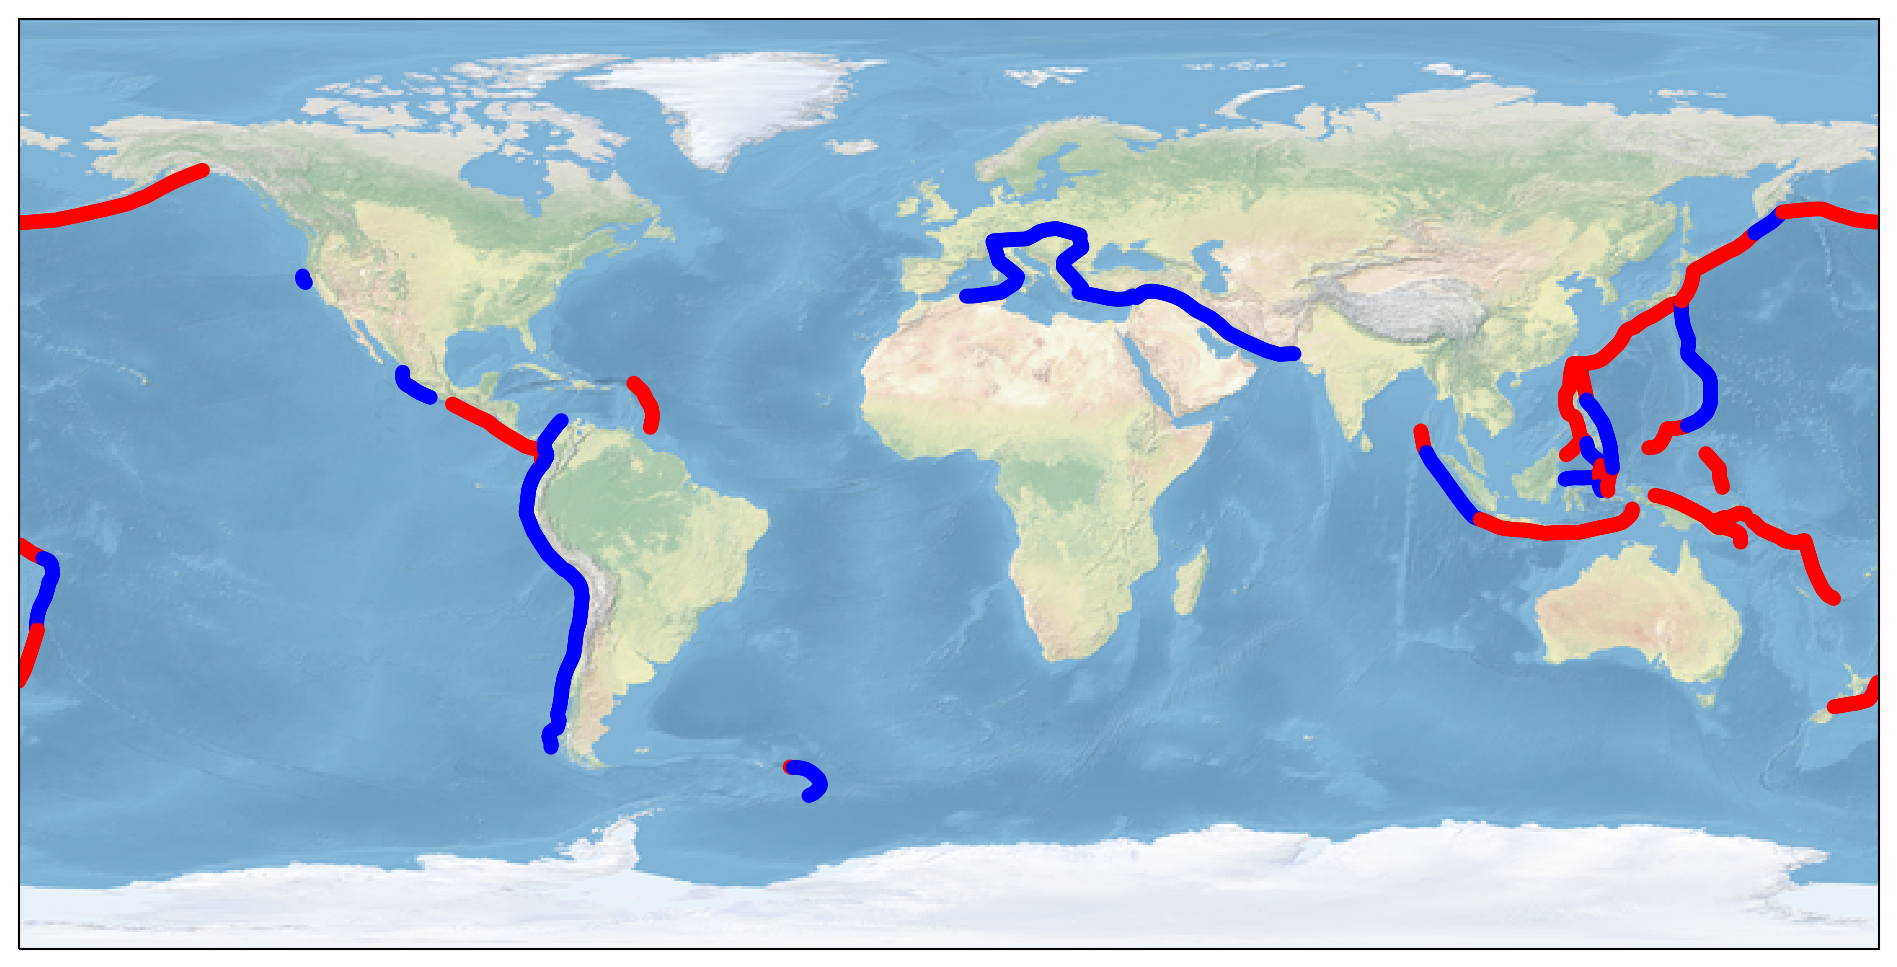

In [20]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-180, 180, -90, 90])

c=[]
for p in test:
    if p[13] == p[14]:
        c.append("blue")
    else:
        c.append("red")

lons = test[:,0]
lats = test[:,1]
plt.scatter(lons,lats,color=c)

plt.show()

In [2]:
from netCDF4 import Dataset
import scipy.spatial
from scipy.signal import decimate
from scipy.interpolate import griddata
import numpy as np
import time, math, pickle, os, urllib
import pygplates
from matplotlib import pyplot as plt
import shapefile

from parameters import parameters as param

# output data
# 
#0 lon
#1 lat
#2 reconstructed lon 
#3 reconstructed lat 
#4 age
#5 time
#6 age at reconstructed location (from age grid)
#7 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
#8 subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
#9 trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
#10 trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
#11 length of arc segment (in degrees) that current point is on
#12 trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
#13 subducting plate ID
#14 trench plate ID
#15 distance (in degrees) along the trench line to the nearest trench edge
#16 the distance (in degrees) along the trench line from the start edge of the trench
#17 convergence velocity orthogonal (in cm/yr)
#18 convergence velocity parallel  (in cm/yr) 
#19 the trench plate absolute velocity orthogonal (in cm/yr)
#20 the trench plate absolute velocity orthogonal (in cm/yr)
#21 the subducting plate absolute velocity magnitude (in cm/yr)
#22 the subducting plate absolute velocityobliquity angle (in degrees)
#23 the subducting plate absolute velocity orthogonal       
#24 the subducting plate absolute velocity parallel
#25 plate id of the input point
ROW_LEN = 26

def main():
    start_time = param["time"]["start"]
    end_time = param["time"]["end"]
    time_step =  param["time"]["step"]

    # input: degrees between two points on sphere
    # output: straight distance between the two points (assume the earth radius is 1)
    # to get the kilometers, use the return value to multiply by the real earth radius
    def degree_to_straight_distance(degree):
        return math.sin(math.radians(degree)) / math.sin(math.radians(90 - degree/2.))


    # the age is a floating-point number. map the floating-point number to the nereast integer time in the range
    def get_time_from_age(ages, start, end, step):
        ret=[]
        times=range(start, end+1, step)
        for age in ages:
            if age <= start:
                ret.append(start)
            elif age >= end:
                ret.append(end)
            else:
                idx = int((age - start)//step)
                mod = (age - start)%step
                if not (mod < step/2.):
                    idx = idx+1 
                ret.append(times[idx])

        return ret  

    # copy the attributes around
    def get_attributes(point, data, index):
        point[7:25] = data[index, 2:20]

    tic=time.time()

    region_1 = param['region_1'] #degrees
    region_2 = param['region_2'] #degrees

    #construct the grid tree
    grid_x, grid_y = np.mgrid[-180:181, -90:91]
    grid_points = [pygplates.PointOnSphere((row[1],row[0])).to_xyz() for row in zip(grid_x.flatten(), grid_y.flatten())]
    grid_tree = scipy.spatial.cKDTree(grid_points)

    #load files
    f = np.loadtxt(param['convergence_data_dir'] + param['convergence_data_filename_prefix'] 
                        + "_0.00." + param['convergence_data_filename_ext'])
    trench_points=f[(f[:,9])==201]
    rotation_model = pygplates.RotationModel(param['rotation_files'])
    reader = shapefile.Reader(param['andes_data'])
    recs    = reader.records()
    andes_points_len = len(recs)
    randomAges=np.random.randint(start_time+1, end_time, size=andes_points_len)
    times = get_time_from_age(np.array(recs)[:,6], start_time, end_time, time_step)

    # create buffer for points
    points=np.full((len(trench_points)*len(range(end_time)) + andes_points_len*2, ROW_LEN), float('nan'))

    # fill the andes deposit points with the real age
    for i in range(andes_points_len):
        points[i][0]=recs[i][3] #lon
        points[i][1]=recs[i][4] #lat
        points[i][4]=recs[i][6] #age
        points[i][5]=times[i] #time
        points[i][-1]=recs[i][7] #plate id

    points_with_age_size=i+1

    # fill andes deposit points with random ages
    for i in range(andes_points_len): 
        points[points_with_age_size+i][0]=recs[i][3] #lon
        points[points_with_age_size+i][1]=recs[i][4] #lat
        points[points_with_age_size+i][4]=randomAges[i] #age
        points[points_with_age_size+i][5]=randomAges[i] #time
        points[points_with_age_size+i][-1]=recs[i][7] #plate id

    points_with_random_age_size=i+1

    # fill trench points for each time step from start_time to end_time
    start_idx = points_with_age_size + points_with_random_age_size
    i=0
    for p in trench_points:
        for t in range(end_time):
            points[start_idx+i][0]=p[0] #lon
            points[start_idx+i][1]=p[1] #lat
            points[start_idx+i][4]=0 #age
            points[start_idx+i][5]=t #time
            points[start_idx+i][-1]=201 #plate id
            i+=1

    poins_all_time_size=i+1 


    sorted_points = sorted(points, key = lambda x: int(x[5])) #sort by time
    from itertools import groupby
    for t, group in groupby(sorted_points, lambda x: int(x[5])):  #group by time
        print(t)
        age_grid_fn = param['age_grid_dir'] + param['age_grid_prefix'] + str(t) + ".nc"
        if not os.path.isfile(age_grid_fn):
            urllib.urlretrieve(param['age_grid_url_prefix']+str(t)+".nc", age_grid_fn)

        rasterfile = Dataset(age_grid_fn,'r')
        z = rasterfile.variables['z'][:] #masked array
        z = z[::10,::10] #TODO: make sure the grid is 1 degree by 1 degree
        z = z.flatten()

        # build the points tree
        data=np.loadtxt(param['convergence_data_dir'] + param['convergence_data_filename_prefix'] 
                        + '_{:0.2f}'.format(t) + "." + param['convergence_data_filename_ext']) 
        
        points_3d = [pygplates.PointOnSphere((row[1],row[0])).to_xyz() for row in data]
        points_tree = scipy.spatial.cKDTree(points_3d)

        # reconstruct the points
        rotated_points = []
        grouped_points = list(group)
        for point in grouped_points:
            point_to_rotate = pygplates.PointOnSphere((point[1], point[0]))
            finite_rotation = rotation_model.get_rotation(point[5], int(point[-1]))
            geom = finite_rotation * point_to_rotate
            rotated_points.append(geom.to_xyz())
            point[3], point[2] = geom.to_lat_lon()

        # query the trees
        dists, indices = points_tree.query(
            rotated_points, k=1, distance_upper_bound=degree_to_straight_distance(region_1)) 
        all_neighbors = grid_tree.query_ball_point(
                rotated_points, 
                degree_to_straight_distance(region_1))

        # get the attributes, query the tree again if necessary
        for point, dist, idx, neighbors in zip(grouped_points, dists, indices, all_neighbors):
            if idx < len(data):
                get_attributes(point, data, idx)
            else:
                #try again with a bigger region
                dist_2, index_2 = points_tree.query(
                    pygplates.PointOnSphere((point[3], point[2])).to_xyz(), 
                    k=1, 
                    distance_upper_bound=degree_to_straight_distance(region_2))
                if index_2 < len(data):
                    get_attributes(point, data, index_2)

            if np.sum(~z[neighbors].mask)>0:
                point[6] = np.nanmean(z[neighbors])
            else: 
                #try again with a bigger region
                neighbors_2 = grid_tree.query_ball_point(
                    pygplates.PointOnSphere((point[3], point[2])).to_xyz(), 
                    degree_to_straight_distance(region_2))
                if np.sum(~z[neighbors_2].mask)>0:
                    point[6] = np.nanmean(z[neighbors_2])

    #print(points)
    np.savetxt('./andes_real_age.csv',points[:points_with_age_size], fmt='%.2f')
    np.savetxt('./andes_random_age.csv',points[points_with_age_size:points_with_random_age_size+points_with_age_size], fmt='%.2f')
    np.savetxt('./trench_points.csv',points[points_with_random_age_size+points_with_age_size:], fmt='%.2f')
    toc=time.time()
    print("Time taken:", toc-tic, " seconds")
    
if __name__ == '__main__':
    main()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
('Time taken:', 85.10115003585815, ' seconds')
